# Read and analyse VTK files from OpenFOAM

## init

In [3]:
%matplotlib inline

In [4]:
# import dolfin as df
#import mshr
import numpy as np
import plot_vtk_matplotlib as pvm

In [5]:
import os
files = os.listdir(".")
for f in files[:15]:
    print(f)

.ipynb_checkpoints
bottom
frontAndBack
inlet
outlet
ppWall_0.vtk
ppWall_100.vtk
ppWall_1000.vtk
ppWall_120.vtk
ppWall_140.vtk
ppWall_160.vtk
ppWall_180.vtk
ppWall_20.vtk
ppWall_200.vtk
ppWall_220.vtk


In [93]:
filename="ppWall_120.vtk"
# Load 
vf_plot = pvm.plot_vtk_matplotlib(filename,z_max=0.001, z_min=-0.001, vtkfiletype="UnstructuredGrid"  )
# Extract the data from the file
vf_plot.extract_data()

## Test what data we have

In [99]:
nodes_array = vf_plot.reader.GetOutput().GetPoints().GetData()
data_arrays = vf_plot.reader.GetOutput().GetPointData()
print data_arrays
pressure_vtk_array = data_arrays.GetArray(0) 
speed_vtk_array = data_arrays.GetArray(1)

vtkPointData (0x8d27a10)
  Debug: Off
  Modified Time: 1020
  Reference Count: 2
  Registered Events: (none)
  Number Of Arrays: 2
  Array 0 name = p
  Array 1 name = U
  Number Of Components: 4
  Number Of Tuples: 882
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)




In [100]:
from vtk.util.numpy_support import vtk_to_numpy
nodes = vtk_to_numpy(nodes_array)
p = vtk_to_numpy(pressure_vtk_array)
U  = vtk_to_numpy(speed_vtk_array)

In [148]:
print nodes.shape
print p.shape
print U.shape
print U

(882, 3)
(882,)
(882, 3)
[[  2.23461259e-02  -4.38232295e-09   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  9.77351606e-01   7.78489218e-11   0.00000000e+00]]


## Merge arrays

In [158]:
print nodes.shape
nodes_part = nodes[:,:2]
print nodes_part.shape
print nodes_part
merged = np.empty([len(nodes),6])
merged[:,0] = p
merged[:,1:3] = U[:,:2]
merged[:,3:] = nodes
print merged.shape

(882, 3)

(882, 2)
[[ 0.          0.        ]
 [ 0.1         0.        ]
 [ 0.2         0.        ]
 ..., 
 [ 1.79999995  0.1       ]
 [ 1.89999998  0.1       ]
 [ 2.          0.1       ]]
(882, 6)


In [163]:
# Check that array merged correctly:
# First column - from p, 
# Columns 2,3 - from U
# Columns 3,4,5 - from nodes
a=510
z=a+3
print merged[a:z]
print "---"
print p[a:z]
print "---"
print U[a:z]
print "---"
print nodes[a:z]


[[  2.31740000e-06   1.49033248e-01  -1.37977255e-10   6.00000024e-01
    1.49999997e-02   9.99999978e-03]
 [  2.13845510e-06   1.49033248e-01   6.86402532e-11   6.99999988e-01
    1.49999997e-02   9.99999978e-03]
 [  2.04984258e-06   1.49033248e-01  -7.97442529e-11   8.00000012e-01
    1.49999997e-02   9.99999978e-03]]
---
[  2.31740000e-06   2.13845510e-06   2.04984258e-06]
---
[[  1.49033248e-01  -1.37977255e-10   0.00000000e+00]
 [  1.49033248e-01   6.86402532e-11   0.00000000e+00]
 [  1.49033248e-01  -7.97442529e-11   0.00000000e+00]]
---
[[ 0.60000002  0.015       0.01      ]
 [ 0.69999999  0.015       0.01      ]
 [ 0.80000001  0.015       0.01      ]]


In [179]:
# Merged z0 and z1 arrays should be same because of 
# the model symmetry along z-axis
merged_z0 = merged[np.where(merged[:,5] == 0)]
merged_z1 = merged[np.where(merged[:,5] != 0)]
dif = merged_z0 - merged_z1
print dif[np.where(dif[:,5] != 0)]

(882, 6)
[[ 0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.   -0.01]
 ..., 
 [ 0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.   -0.01]]


In [183]:
# Extract nodes, p and U arrays from z0 array
p = merged_z0[:,0]
U = merged_z0[:,1:3]
nodes = merged_z0[:,3:5]
print p.shape
print U.shape
print nodes.shape

(441,)
(441, 2)
(441, 2)


In [339]:
for i in range(0,nodes.shape[0]):
    print("{:3d} {:4.2f}:{:4.2f} p{:.1f} U[{u[0]:.2f} {u[1]:.2f}] xy[{n[0]:.2f} {n[1]:.2f}]"
          .format(i,nodes[i][0],nodes[i][1], p[i],u=U[i], n=nodes[i]))

  0 0.00:0.00 p0.0 U[0.02 -0.00] xy[0.00 0.00]
  1 0.10:0.00 p0.0 U[0.00 0.00] xy[0.10 0.00]
  2 0.20:0.00 p0.0 U[0.00 0.00] xy[0.20 0.00]
  3 0.30:0.00 p0.0 U[0.00 0.00] xy[0.30 0.00]
  4 0.40:0.00 p0.0 U[0.00 0.00] xy[0.40 0.00]
  5 0.50:0.00 p0.0 U[0.00 0.00] xy[0.50 0.00]
  6 0.60:0.00 p0.0 U[0.00 0.00] xy[0.60 0.00]
  7 0.70:0.00 p0.0 U[0.00 0.00] xy[0.70 0.00]
  8 0.80:0.00 p0.0 U[0.00 0.00] xy[0.80 0.00]
  9 0.90:0.00 p0.0 U[0.00 0.00] xy[0.90 0.00]
 10 1.00:0.00 p0.0 U[0.00 0.00] xy[1.00 0.00]
 11 1.10:0.00 p0.0 U[0.00 0.00] xy[1.10 0.00]
 12 1.20:0.00 p0.0 U[0.00 0.00] xy[1.20 0.00]
 13 1.30:0.00 p0.0 U[0.00 0.00] xy[1.30 0.00]
 14 1.40:0.00 p0.0 U[0.00 0.00] xy[1.40 0.00]
 15 1.50:0.00 p0.0 U[0.00 0.00] xy[1.50 0.00]
 16 1.60:0.00 p0.0 U[0.00 0.00] xy[1.60 0.00]
 17 1.70:0.00 p0.0 U[0.00 0.00] xy[1.70 0.00]
 18 1.80:0.00 p0.0 U[0.00 0.00] xy[1.80 0.00]
 19 1.90:0.00 p0.0 U[0.00 0.00] xy[1.90 0.00]
 20 2.00:0.00 p0.0 U[0.02 -0.00] xy[2.00 0.00]
 21 0.00:0.00 p0.0 U[0.05 -0.00]

## Plot pressure

In [304]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


p_max = np.amax(p)
p_min = np.amin(p)
print("p: {:12.9f} - {:12.9f}".format(p_min, p_max))
U_max = np.amax(U)
U_min = np.amin(U)
print("U: {:12.9f} - {:12.9f}".format(U_min, U_max))


p:  0.000000000 -  0.000005263
U: -0.000000157 -  1.000000000


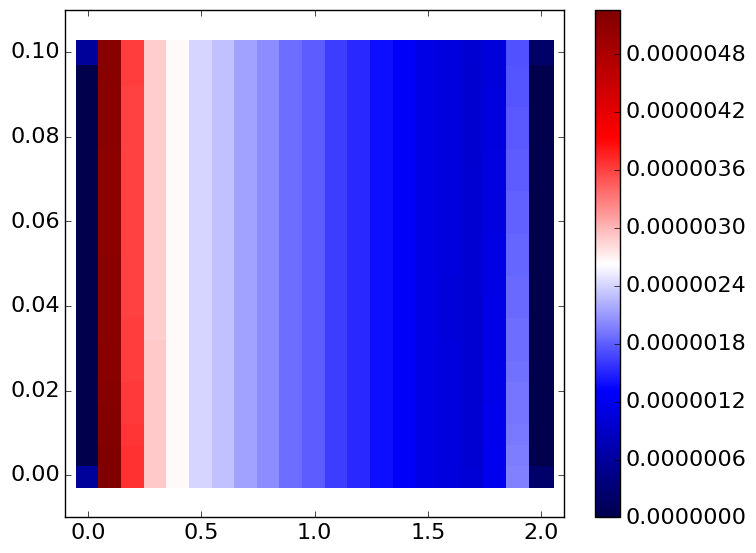

In [371]:
# 2d plotting
fig = plt.figure(figsize=(8,6))
cmap = mpl.cm.plasma
color_map = plt.cm.get_cmap('seismic')
axes = plt.gca()
axes.set_xlim([-.1,2.1])
axes.set_ylim([-.01,0.11])
#plt.axis('off')
sc = plt.scatter(nodes[:,0],nodes[:,1],
                 s=320,
#                 color=cmap(p / p_max),
                 c = p,
                 cmap = color_map,
                 linewidth='0', 
                 marker="s")
plt.colorbar(sc)
fig.tight_layout()
plt.savefig("ppWall_120.png",bbox_inches='tight')

## Plot speed vectors

In [330]:
# Test vector length calculation
a = np.array([[1,2],[3,4]])
b = np.sqrt(a[:,0]**2 + a[:,1]**2)
print a
print b.T


# Coordinates of vectors tips
U_tips = nodes + U
U_norm = np.sqrt(U[:,0]**2 + U[:,1]**2)
for i in range(0,U.shape[0]):
    print("{:2d} ||{:12.8f},{:12.8f}||={:12.8f}".format(i, U[i,0], U[i,1], U_norm[i]))
#print U_norm
#print U_tips
 

[[1 2]
 [3 4]]
[ 2.23606798  5.        ]
 0 ||  0.02234613, -0.00000000||=  0.02234613
 1 ||  0.00000000,  0.00000000||=  0.00000000
 2 ||  0.00000000,  0.00000000||=  0.00000000
 3 ||  0.00000000,  0.00000000||=  0.00000000
 4 ||  0.00000000,  0.00000000||=  0.00000000
 5 ||  0.00000000,  0.00000000||=  0.00000000
 6 ||  0.00000000,  0.00000000||=  0.00000000
 7 ||  0.00000000,  0.00000000||=  0.00000000
 8 ||  0.00000000,  0.00000000||=  0.00000000
 9 ||  0.00000000,  0.00000000||=  0.00000000
10 ||  0.00000000,  0.00000000||=  0.00000000
11 ||  0.00000000,  0.00000000||=  0.00000000
12 ||  0.00000000,  0.00000000||=  0.00000000
13 ||  0.00000000,  0.00000000||=  0.00000000
14 ||  0.00000000,  0.00000000||=  0.00000000
15 ||  0.00000000,  0.00000000||=  0.00000000
16 ||  0.00000000,  0.00000000||=  0.00000000
17 ||  0.00000000,  0.00000000||=  0.00000000
18 ||  0.00000000,  0.00000000||=  0.00000000
19 ||  0.00000000,  0.00000000||=  0.00000000
20 ||  0.02234658, -0.00000000||=  0.02

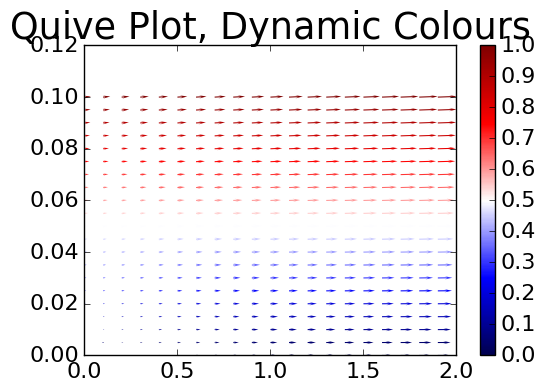

In [332]:
# Plot vector field
# Sample code from here: 
# https://www.getdatajoy.com/examples/python-plots/vector-fields

plot1 = plt.figure()
plt.quiver(nodes[:,0],nodes[:,1],
           U_tips[:,0],U_tips[:,1],
           U_norm,
           cmap=plt.cm.seismic,
           headlength=7)        # length of the arrows

plt.colorbar()                  # adds the colour bar

plt.title('Quive Plot, Dynamic Colours')
plt.show(plot1)

## Same data for p, 3d plotting with z=0

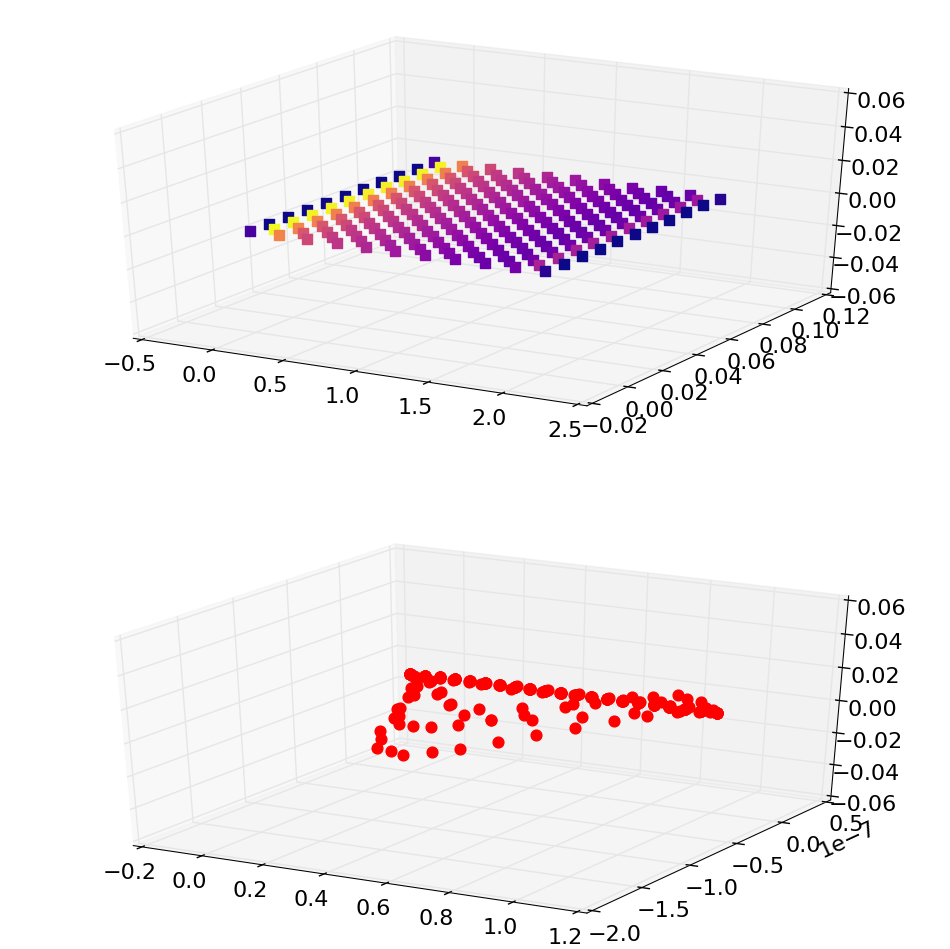

In [333]:
# 3d plotting

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211, projection='3d')
for i in range(0,len(nodes),2):
    ax1.scatter(nodes[i][0],nodes[i][1],0,s=60,color=cmap(p[i] / p_max),marker='s')
ax2 = fig.add_subplot(212, projection='3d')
for i in range(0,len(nodes),2):
#    ax2.scatter(nodes[i][0],nodes[i][1],0,s=60,color=cmap(U[i] / U_max),marker='s')
    ax2.scatter(U[i][0],U[i][1],0,s=60,color='r',marker='o')
plt.show()

# Test vtk_to_numpy
http://stackoverflow.com/questions/23138112/vtk-to-maplotlib-using-numpy

In [355]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import vtk
from vtk.util.numpy_support import vtk_to_numpy

# load a vtk file as input
reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName("ppWall_120.vtk")
reader.Update()

# Get the coordinates of nodes in the mesh
nodes_vtk_array= reader.GetOutput().GetPoints().GetData()
print "Data:"
print reader.GetOutput().GetPointData()

#The "Temperature" field is the third scalar in my vtk file
pressure_vtk_array = reader.GetOutput().GetPointData().GetArray(0)
speed_vtk_array = reader.GetOutput().GetPointData().GetArray(1)
p_ = vtk_to_numpy(pressure_vtk_array)
U_  = vtk_to_numpy(speed_vtk_array)
print p_
print U_

Data:
vtkPointData (0xb8eac70)
  Debug: Off
  Modified Time: 1241
  Reference Count: 2
  Registered Events: (none)
  Number Of Arrays: 2
  Array 0 name = p
  Array 1 name = U
  Number Of Components: 4
  Number Of Tuples: 882
  Copy Tuple Flags: ( 1 1 1 1 1 0 1 1 )
  Interpolate Flags: ( 1 1 1 1 1 0 0 1 )
  Pass Through Flags: ( 1 1 1 1 1 1 1 1 )
  Scalars: (none)
  Vectors: (none)
  Normals: (none)
  TCoords: (none)
  Tensors: (none)
  GlobalIds: (none)
  PedigreeIds: (none)
  EdgeFlag: (none)


[  5.86855492e-07   5.26256508e-06   3.69278496e-06   2.91200490e-06
   2.66141501e-06   2.41359498e-06   2.31752006e-06   2.13852991e-06
   2.04984008e-06   1.88621505e-06   1.79237998e-06   1.63533002e-06
   1.53768497e-06   1.38461496e-06   1.28749002e-06   1.14250497e-06
   1.07023004e-06   1.00755256e-06   1.20844754e-06   1.98250996e-06
   2.43593831e-07   0.00000000e+00   5.24830011e-06   3.68440260e-06
   2.91073002e-06   2.66107509e-06   2.41349994e-06   2.31748254e-06
   2.13852240e-0

In [89]:
cmap = mpl.cm.plasma
p_max = np.amax(p_)
print p_max
U_max = np.amax(U_)
print U_max

5.26257e-06
1.0


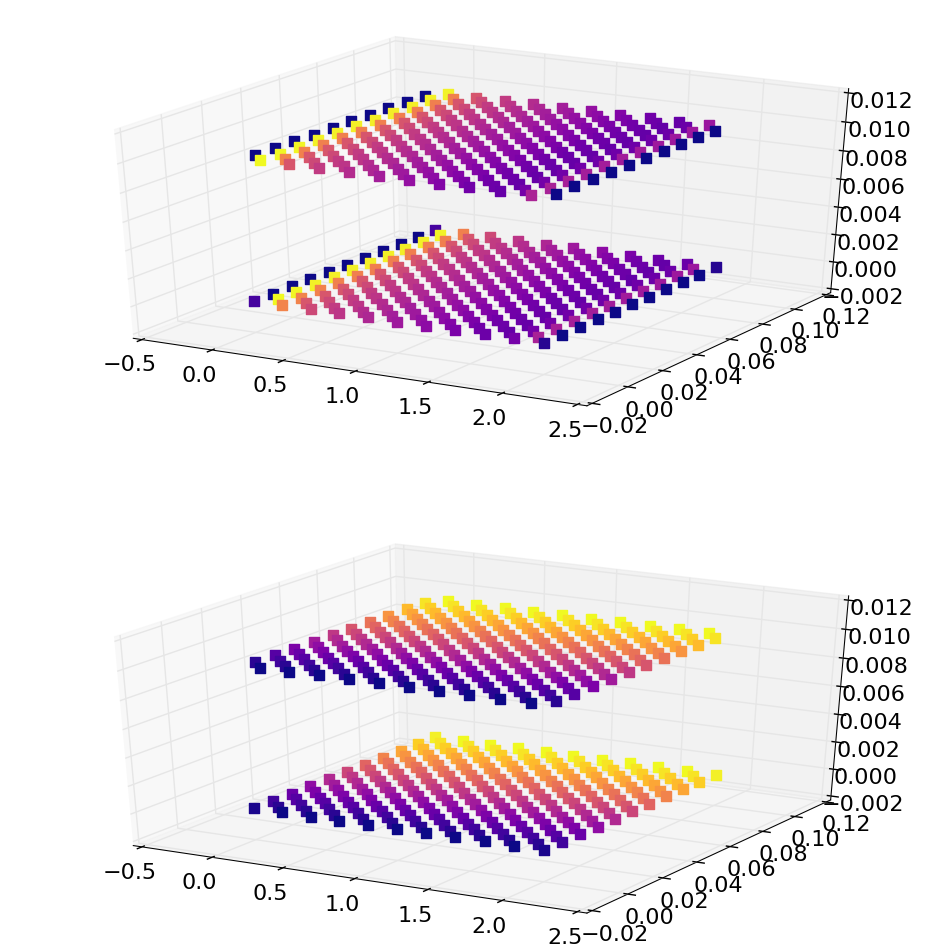

In [90]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211, projection='3d')
for i in range(0,len(nodes),2):
    ax1.scatter(nodes[i][0],nodes[i][1],nodes[i][2],s=60,color=cmap(p_[i] / p_max),marker='s')
ax2 = fig.add_subplot(212, projection='3d')
for i in range(0,len(nodes),2):
    ax2.scatter(nodes[i][0],nodes[i][1],nodes[i][2],s=60,color=cmap(U_[i] / U_max),marker='s')
plt.show()

# Test works fine. Next: write a function for reading partular file and plotting its data.